**Candidate Name:** Sneha Santha Prabakar

**Week 9:** Assignment Part 2 - CLIP

# Image classification with CLIP

In this notebook, we explore how to use CLIP to classify images using zero-shot classification.
We will apply the following steps:
* Install required packages
* Load a dataset (CIFAR10 here)
* Classify all the images of the dataset
* Compute several metrics and display the confusion matrix

## Install required packages

In [ ]:
#Restart session after running this
!pip install -U fsspec==2023.6.0
!pip install transformers torch datasets matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.6.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64

## Load CLIP: model, processor and tokenizer using transformers
Firstly, import the required packages.
Then, define the device to use (i.e gpu or cpu).
Lastly, load CLIP model, processor and tokenizer using Transformers.

In [ ]:
#Import packages
import torch
from PIL import Image
from transformers import AutoProcessor, CLIPModel, AutoTokenizer
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from datasets import load_dataset
from tqdm import tqdm

#Define device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

#Load CLIP model, processor and tokenizer
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

## Load CIFAR 10 dataset
We use this dataset as it has 10 pre-defined classes.

In [ ]:
# Clear only the contents inside the datasets cache
!rm -rf ~/.cache/huggingface/datasets/*

# Load the datasets library
from datasets import load_dataset

# Load CIFAR-10 dataset
dataset = load_dataset("cifar10")

# Display the list of labels
labels = dataset["train"].features["label"].names
print(labels)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Classification of one image
Firstly, we are going to classify an image using CLIP to see how it works.
We define a function named "classify", which takes as input an image and a list of labels, and returns the label with the highest classification score.

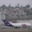

airplane


In [ ]:
#Take the first image in the training set
image = dataset['train'][0]['img']

#Function to classify an image among the list of labels
def classify(image, labels):
    inputs = processor(text=labels, images=image, return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    label = probs.argmax()
    return label

l = classify(image,labels)
#Display the first image in the dataset and its predicted class (i.e. airplane, which is correct)
display(image)
print(labels[l])

## Classification of all the images in the test set (10k images)
We are now going to use the same method on the test set of the CIFAR dataset.
We create a variable named "predictions", which will store the predicted label for each image. In order to compute several metrics afterwards, we also store the ground truth.
First step: we iterate over the dataset, classify all the images and store the predicted labels.

In [ ]:
predictions= []
ground_truth= [d['label'] for d in dataset['test']]

for img in tqdm(dataset['test']):
    pred = classify(img['img'], labels)
    predictions.append(pred.item())

100%|██████████| 10000/10000 [04:45<00:00, 34.99it/s]


In order to assess the performance of the classification, we compute a set of metrics, using the functions available in the sklearn module.
We will more particularly look into: accuracy, precision, recall and f1-score. We also compute the confusion matrix to get insights into what classes were misclassified.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
y_true = ground_truth
y_pred = predictions

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(y_true, y_pred, average='weighted')
print(f'Precision: {precision:.4f}')

recall = recall_score(y_true, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')

f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1:.4f}')

# Generate classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:')
print(conf_matrix)

Accuracy: 0.8735
Precision: 0.8810
Recall: 0.8735
F1 Score: 0.8734

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1000
           1       0.93      0.90      0.91      1000
           2       0.73      0.92      0.81      1000
           3       0.89      0.79      0.84      1000
           4       0.89      0.82      0.85      1000
           5       0.89      0.85      0.87      1000
           6       0.96      0.77      0.85      1000
           7       0.81      0.97      0.88      1000
           8       0.90      0.96      0.93      1000
           9       0.89      0.94      0.91      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000


Confusion Matrix:
[[811   7 119   0   0   0   2   0  45  16]
 [  2 897   0   0   0   0   0   1   5  95]
 [  5   1 916   8  25   9   3  32   1   0]
 [

We plot the confusion matrix to make it more human readable.

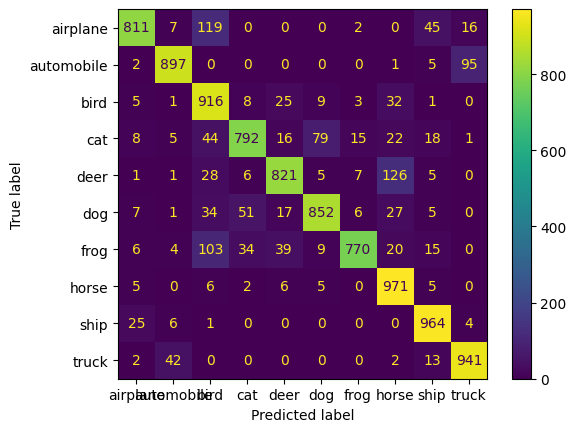

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=labels)
disp.plot()
plt.show()

## Analysis
CLIP demonstrated a commendable accuracy at 87.3%.
The confusion matrix reveals lower recall rates for frogs and cats. Frogs were frequently misclassified as birds, while cats were commonly misclassified as dogs.
The upcoming section delves into prompt engineering, offering insights into potential enhancements for the achieved scores.


The [CLIP paper](https://arxiv.org/pdf/2103.00020.pdf) explains that it is relatively rare in the training set to encounter an image being described with a unique word. Therefore, adding "a photo of" before the label improved accuracy by 1.3% on ImageNet.
We will experiment with it here and assess whether we observe any improvements.

In [ ]:
#Define new labels
new_labels = [f"a photo of {label}" for label in labels]
print(new_labels)

['a photo of airplane', 'a photo of automobile', 'a photo of bird', 'a photo of cat', 'a photo of deer', 'a photo of dog', 'a photo of frog', 'a photo of horse', 'a photo of ship', 'a photo of truck']


Reusing the code above, we get:

In [ ]:
predictions= []
ground_truth= [d['label'] for d in dataset['test']]

for img in tqdm(dataset['test']):
    pred = classify(img['img'], new_labels)
    predictions.append(pred.item())

100%|██████████| 10000/10000 [04:23<00:00, 37.96it/s]


Accuracy: 0.8895
Precision: 0.8930
Recall: 0.8895
F1 Score: 0.8892

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1000
           1       0.91      0.96      0.93      1000
           2       0.86      0.88      0.87      1000
           3       0.86      0.82      0.84      1000
           4       0.92      0.79      0.85      1000
           5       0.87      0.88      0.87      1000
           6       0.95      0.81      0.88      1000
           7       0.83      0.96      0.89      1000
           8       0.97      0.94      0.95      1000
           9       0.94      0.92      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Confusion Matrix:
[[931   8  34   0   0   0   0   0  15  12]
 [  3 956   0   0   0   1   0   0   2  38]
 [ 31   2 882  12  26   9  10  27   1   0]
 [

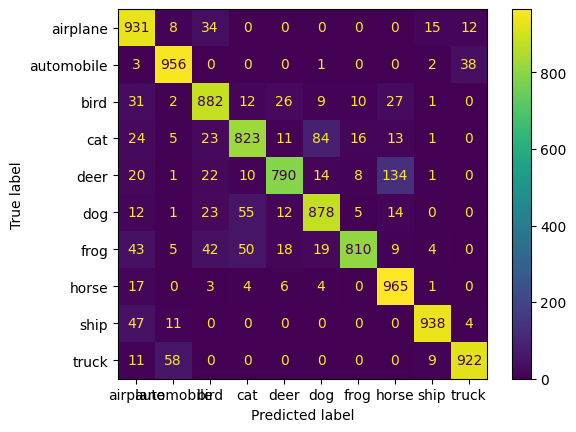

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay # Ensure ConfusionMatrixDisplay is imported
import matplotlib.pyplot as plt
y_true = ground_truth
y_pred = predictions

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(y_true, y_pred, average='weighted')
print(f'Precision: {precision:.4f}')

recall = recall_score(y_true, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')

f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1:.4f}')

# Generate classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:')
print(conf_matrix)

#With plot only labels and  not new_label for the sake of visibility
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=labels)
disp.plot()
plt.show()

With the application of straightforward prompt engineering, we successfully increased the accuracy score by 1.6%. To conclude, the fine-tuning of prompts has the potential to generate even more substantial improvements.